# ODYM Example no. 5. Estimating the material content of the global vehicle fleet

ODYM was designed to handle extensive MFA systems by covering multiple aspects (time, age-cohort, region, material, chemical elements, processes, goods, components, ...) in a systematic manner. Its data format is used to structure and store input data, its software structure determines how the information is organised in the computer, and its application scripts provide a working environment for conducting reproducible dynamic MFA research with comprehensive and multi-aspect systems.

This example shows a fully-fledged application of ODYM to estimate the material composition of the global passenger vehicle fleet in 2017, covering 130 countries, 25 age-cohorts, and 25 materials. The application is controlled by a config file, reads the model parameters in standard format, performs the model computations and a Monte-Carlo simulation of the uncertainties stemming from vehicle lifetime and material composition, performs automatic mass balance checks, and stores the model procedures in a log file.

The research questions asked are: __How big is the material stock currently embodied in the global passenger vehicle fleet, and when will this material become available for recycling?__

To answer these questions a dynamic material flow analysis of the global passenger vehicle fleet and the waste management industries is performed.

The dynamic MFA model has the following indices:
+ t: time (1990-2017)
+ c: age-cohort (1990-2017)
+ r: region (130 countries accounting for most of the global vehicle fleet)
+ g: good (passenger vehicle)
+ p: process (vehicle markets, use phase, waste management industries, scrap markets)
+ m: engineering materials (25)
+ e: chemical elements (all)
+ w: waste types (steel, Al, Cu scrap, plastics, glass, and other waste)

The system definition of the model is given in the figure below. The data availability limits the temporal scope to 2017. The figure also shows the aspects of the different system variables. The total registration of vehicles, for example, is broken down into individual materials, whereas the flow of deregistered vehicles is broken down into regions, age-cohorts, and materials.

<img src="Images/ODYM_Tutorial5_SysDef.png" width="850" height="290" alt="ODYM_Tutorial5 System Definition">

The model equations are as follows:

1) inflow-driven dynamic stock model, where _F12_ is the historic inflow, _Sf_ is the survival function of the age-cohort (1-sum(pdf of discard)), and _S2_ is the stock:
$$S_2(t,c,r,g) = F_{1-2}(c,r,g)\cdot Sf(t,c,r,g)$$

2) Calculation of difference between inflow-driven stock (covering only the age-cohorts 2005-2017 due to data availability) and the 2015 reported stock and distribution of the difference to the years 1990-2005 (constant inflow assumed for these years)

3) Calculation of material composition of the fleet _S2_ with

$$S_2(t,c,r,g,m) = \mu(c,r,g,m)\cdot S_2(t,c,r,g)$$

4) Estimation of available future end-of-life vehicle scrap _F34_ with
$$F_{3-4}(r,g,w,m) = \sum_{t,c}EoL_eff(r,g,m,w)\cdot M(t,c,r,g,m)$$

The remaining system variables are calculated by mass balance.

__Model choice:__ Because the system covers region, material, waste, and chemical element aspects and a dynamic stock model, a simple calculation in Excel would be too laborious and the potential for testing and quick re-use of data and programming would be limited. Instead, the ODYM framework is chosen to structure the model data and calculations.

### 1) Load ODYM

In [1]:
# Load a local copy of the current ODYM branch:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import xlrd, xlwt
import pylab
from copy import deepcopy
import logging as log

# For Ipython Notebook only
%matplotlib inline

# add ODYM module directory to system path, relative
MainPath = os.path.join('..', 'odym', 'modules')
sys.path.insert(0, MainPath)

# add ODYM module directory to system path, absolute
sys.path.insert(0, os.path.join(os.getcwd(),'..', 'odym', 'modules'))

# Specify path to dynamic stock model and to datafile, relative
DataPath = os.path.join('..', 'docs', 'files')

# Specify path to dynamic stock model and to datafile, absolute
DataPath = os.path.join(os.getcwd(),'..', 'docs', 'files')

import ODYM_Classes as msc # import the ODYM class file
import ODYM_Functions as msf # import the ODYM function file
import dynamic_stock_model as dsm # import the dynamic stock model library

# Initialize loggin routine
log_verbosity = eval("log.DEBUG")
log_filename = 'LogFileTest.md'
[Mylog, console_log, file_log] = msf.function_logger(log_filename, os.getcwd(),
                                                     log_verbosity, log_verbosity)
Mylog.info('### 1. - Initialize.')

INFO (<ipython-input-1-17a5a9bcfdc9> <<module>>): ### 1. - Initialize.
DEBUG (pyplot.py <switch_backend>): Loaded backend module://ipykernel.pylab.backend_inline version unknown.


### 2) Load Config file and read model control parameters

In [2]:
Mylog.info('### 2 - Load Config file and read model control parameters')
#Read main script parameters
#Load project-specific config file
ProjectSpecs_Name_ConFile = 'ODYM_Config_Tutorial5.xlsx'
Model_Configfile = xlrd.open_workbook(os.path.join(DataPath, ProjectSpecs_Name_ConFile))
ScriptConfig = {'Model Setting': Model_Configfile.sheet_by_name('Config').cell_value(3,3)}
Model_Configsheet = Model_Configfile.sheet_by_name('Setting_' + ScriptConfig['Model Setting'])

Name_Scenario            = Model_Configsheet.cell_value(3,3)
print(Name_Scenario)

### 1.2) Read model control parameters
#Read control and selection parameters into dictionary
SCix = 0
# search for script config list entry
while Model_Configsheet.cell_value(SCix, 1) != 'General Info':
    SCix += 1
        
SCix += 2  # start on first data row
while len(Model_Configsheet.cell_value(SCix, 3)) > 0:
    ScriptConfig[Model_Configsheet.cell_value(SCix, 2)] = Model_Configsheet.cell_value(SCix,3)
    SCix += 1

SCix = 0
# search for script config list entry
while Model_Configsheet.cell_value(SCix, 1) != 'Software version selection':
    SCix += 1
        
SCix += 2 # start on first data row
while len(Model_Configsheet.cell_value(SCix, 3)) > 0:
    ScriptConfig[Model_Configsheet.cell_value(SCix, 2)] = Model_Configsheet.cell_value(SCix,3)
    SCix += 1 
    
print(ScriptConfig)    

INFO (<ipython-input-2-6dff43160462> <<module>>): ### 2 - Load Config file and read model control parameters


ODYM_Tutorial5
{'Model Setting': 'Tutorial5', 'Name of model setting': 'ODYM_Tutorial5', 'Description': 'Estimating the material composition of the global passenger vehicle fleet', 'Name of model script used': 'ODYM_Tutorial_5', 'Version of master classification': 'ODYM_Classifications_Master_Tutorial', 'Version of ODYM Classes': 'V01', 'Version of ODYM Functions': 'V01'}


### 3) Read classification and data

In [3]:
Mylog.info('### 3 - Read classification and data')
# This is standard for each ODYM model run.

# Read model run config data
Classfile  = xlrd.open_workbook(os.path.join(DataPath, 
                                             str(ScriptConfig['Version of master classification']) \
                                             + '.xlsx'))
Classsheet = Classfile.sheet_by_name('MAIN_Table')
ci = 1 # column index to start with
MasterClassification = {} # Dict of master classifications
while True:
    TheseItems = []
    ri = 10 # row index to start with    
    try: 
        ThisName = Classsheet.cell_value(0,ci)
        ThisDim  = Classsheet.cell_value(1,ci)
        ThisID   = Classsheet.cell_value(3,ci)
        ThisUUID = Classsheet.cell_value(4,ci)
        TheseItems.append(Classsheet.cell_value(ri,ci)) # read the first classification item
    except:
        print('End of file or formatting error while reading the classification file in column '+ str(ci) +'.')
        break
    while True:
        ri +=1
        try:
            ThisItem = Classsheet.cell_value(ri,ci)
        except:
            break
        if ThisItem is not '':
            TheseItems.append(ThisItem)
    MasterClassification[ThisName] = msc.Classification(Name = ThisName, Dimension = ThisDim, 
                                                        ID = ThisID, UUID = ThisUUID, Items = TheseItems)
    ci +=1 
    
print('Read index table from model config sheet.')
ITix = 0
while True: # search for index table entry
    if Model_Configsheet.cell_value(ITix,1) == 'Index Table':
        break
    else:
        ITix += 1
        
IT_Aspects        = []
IT_Description    = []
IT_Dimension      = []
IT_Classification = []
IT_Selector       = []
IT_IndexLetter    = []
ITix += 2 # start on first data row
while True:
    if len(Model_Configsheet.cell_value(ITix,2)) > 0:
        IT_Aspects.append(Model_Configsheet.cell_value(ITix,2))
        IT_Description.append(Model_Configsheet.cell_value(ITix,3))
        IT_Dimension.append(Model_Configsheet.cell_value(ITix,4))
        IT_Classification.append(Model_Configsheet.cell_value(ITix,5))
        IT_Selector.append(Model_Configsheet.cell_value(ITix,6))
        IT_IndexLetter.append(Model_Configsheet.cell_value(ITix,7))        
        ITix += 1
    else:
        break

print('Read parameter list from model config sheet.')
PLix = 0
while True: # search for parameter list entry
    if Model_Configsheet.cell_value(PLix,1) == 'Model Parameters':
        break
    else:
        PLix += 1
        
PL_Names          = []
PL_Description    = []
PL_Version        = []
PL_IndexStructure = []
PL_IndexMatch     = []
PL_IndexLayer     = []
PLix += 2 # start on first data row
while True:
    if len(Model_Configsheet.cell_value(PLix,2)) > 0:
        PL_Names.append(Model_Configsheet.cell_value(PLix,2))
        PL_Description.append(Model_Configsheet.cell_value(PLix,3))
        PL_Version.append(Model_Configsheet.cell_value(PLix,4))
        PL_IndexStructure.append(Model_Configsheet.cell_value(PLix,5))
        PL_IndexMatch.append(Model_Configsheet.cell_value(PLix,6))
        # strip numbers out of list string
        PL_IndexLayer.append(msf.ListStringToListNumbers(Model_Configsheet.cell_value(PLix,7))) 
        PLix += 1
    else:
        break
    
print('Read process list from model config sheet.')
PrLix = 0
while True: # search for process list entry
    if Model_Configsheet.cell_value(PrLix,1) == 'Process Group List':
        break
    else:
        PrLix += 1
        
PrL_Number         = []
PrL_Name           = []
PrL_Code           = []
PrL_Type           = []
PrLix += 2 # start on first data row
while True:
    if Model_Configsheet.cell_value(PrLix,2) != '':
        try:
            PrL_Number.append(int(Model_Configsheet.cell_value(PrLix,2)))
        except:
            PrL_Number.append(Model_Configsheet.cell_value(PrLix,2))
        PrL_Name.append(Model_Configsheet.cell_value(PrLix,3))
        PrL_Code.append(Model_Configsheet.cell_value(PrLix,4))
        PrL_Type.append(Model_Configsheet.cell_value(PrLix,5))
        PrLix += 1
    else:
        break    

print('Read model run control from model config sheet.')
PrLix = 0
while True: # search for model flow control entry
    if Model_Configsheet.cell_value(PrLix,1) == 'Model flow control':
        break
    else:
        PrLix += 1
        
PrLix += 2 # start on first data row
while True:
    if Model_Configsheet.cell_value(PrLix,2) != '':
        try:
            ScriptConfig[Model_Configsheet.cell_value(PrLix,2)] = Model_Configsheet.cell_value(PrLix,3)
        except:
            None
        PrLix += 1
    else:
        break  

INFO (<ipython-input-3-2b51f73ef3ca> <<module>>): ### 3 - Read classification and data


End of file or formatting error while reading the classification file in column 11.
Read index table from model config sheet.
Read parameter list from model config sheet.
Read process list from model config sheet.
Read model run control from model config sheet.


In [4]:
print('Define model classifications and select items for model classifications according to information provided by config file.')
ModelClassification  = {} # Dict of model classifications
for m in range(0,len(IT_Aspects)):
    ModelClassification[IT_Aspects[m]] = deepcopy(MasterClassification[IT_Classification[m]])
    EvalString = msf.EvalItemSelectString(IT_Selector[m],len(ModelClassification[IT_Aspects[m]].Items))
    if EvalString.find(':') > -1: # range of items is taken
        RangeStart = int(EvalString[0:EvalString.find(':')])
        RangeStop  = int(EvalString[EvalString.find(':')+1::])
        ModelClassification[IT_Aspects[m]].Items = ModelClassification[IT_Aspects[m]].Items[RangeStart:RangeStop]           
    elif EvalString.find('[') > -1: # selected items are taken
        ModelClassification[IT_Aspects[m]].Items = \
            [ModelClassification[IT_Aspects[m]].Items[i] for i in eval(EvalString)]
    elif EvalString == 'all':
        None
    else:
        Mylog.info('ITEM SELECT ERROR for aspect ' + IT_Aspects[m] + ' were found in datafile.</br>')
        break

Define model classifications and select items for model classifications according to information provided by config file.


The following code block creates the index table for the MFA system and parses all parameter files specified into the parameter dictionary ParameterDict.

In [5]:
# Define model index table and parameter dictionary
Model_Time_Start = int(min(ModelClassification['Time'].Items))
Model_Time_End   = int(max(ModelClassification['Time'].Items))
Model_Duration   = Model_Time_End - Model_Time_Start

print('Define index table dataframe.')
IndexTable = pd.DataFrame({'Aspect'        : IT_Aspects, # 'Time' and 'Element' must be present!
                           'Description'   : IT_Description,
                           'Dimension'     : IT_Dimension,
                           'Classification': [ModelClassification[Aspect] for Aspect in IT_Aspects],
                           # Unique one letter (upper or lower case) indices to be used later for calculations.
                           'IndexLetter'   : IT_IndexLetter}) 

# Default indexing of IndexTable, other indices are produced on the fly
IndexTable.set_index('Aspect', inplace = True) 

# Add indexSize to IndexTable:
IndexTable['IndexSize'] = \
    pd.Series([len(IndexTable.Classification[i].Items) for i in range(0,len(IndexTable.IndexLetter))], index=IndexTable.index)

# list of the classifications used for each indexletter
IndexTable_ClassificationNames = [IndexTable.Classification[i].Name for i in range(0,len(IndexTable.IndexLetter))] 

#Define shortcuts for the most important index sizes:
Nt = len(IndexTable.Classification[IndexTable.index.get_loc('Time')].Items)
NR = len(IndexTable.Classification[IndexTable.set_index('IndexLetter').index.get_loc('r')].Items)
NG = len(IndexTable.Classification[IndexTable.set_index('IndexLetter').index.get_loc('g')].Items)
NM = len(IndexTable.Classification[IndexTable.set_index('IndexLetter').index.get_loc('m')].Items)
print('Read model data and parameters.')

ParameterDict = {}
for mo in range(0,len(PL_Names)):
    ParPath = os.path.join(DataPath,PL_Version[mo])
    print('Reading parameter ' + PL_Names[mo])
    # Do not change order of parameters handed over to function!
    MetaData, Values, Uncertainty = msf.ReadParameterV2(ParPath, PL_Names[mo], PL_IndexStructure[mo], 
                                         PL_IndexMatch[mo], PL_IndexLayer[mo],
                                         MasterClassification, IndexTable,
                                         IndexTable_ClassificationNames, ScriptConfig, Mylog, ParseUncertainty = True) 
    ParameterDict[PL_Names[mo]] = msc.Parameter(Name = MetaData['Dataset_Name'], 
                                                ID = MetaData['Dataset_ID'], 
                                                UUID = MetaData['Dataset_UUID'],
                                                P_Res = None,
                                                MetaData = MetaData,
                                                Indices = PL_IndexStructure[mo], 
                                                Values=Values, 
                                                Uncert=Uncertainty,
                                                Unit = MetaData['Dataset_Unit'])

Define index table dataframe.
Read model data and parameters.
Reading parameter ODYM_Tutorial5_VehicleLifetime


INFO (ODYM_Functions.py <ReadParameterV2>): A total of 130 values was read from file for parameter ODYM_Tutorial5_VehicleLifetime.
INFO (ODYM_Functions.py <ReadParameterV2>): 130.0 of 7930 values for parameter ODYM_Tutorial5_VehicleLifetime were assigned.
INFO (ODYM_Functions.py <ReadParameterV2>): A total of 25 values was read from file for parameter ODYM_Tutorial5_VehicleMaterialContent.
INFO (ODYM_Functions.py <ReadParameterV2>): 25.0 of 198250 values for parameter ODYM_Tutorial5_VehicleMaterialContent were assigned.


Reading parameter ODYM_Tutorial5_VehicleMaterialContent
Reading parameter ODYM_Tutorial5_VehicleNewRegistration


INFO (ODYM_Functions.py <ReadParameterV2>): A total of 1924 values was read from file for parameter ODYM_Tutorial5_VehicleNewRegistration.
INFO (ODYM_Functions.py <ReadParameterV2>): 1690.0 of 7930 values for parameter ODYM_Tutorial5_VehicleNewRegistration were assigned.


Reading parameter ODYM_Tutorial5_VehicleStock2015


INFO (ODYM_Functions.py <ReadParameterV2>): A total of 145 values was read from file for parameter ODYM_Tutorial5_VehicleStock2015.
INFO (ODYM_Functions.py <ReadParameterV2>): 129.0 of 7930 values for parameter ODYM_Tutorial5_VehicleStock2015 were assigned.
INFO (ODYM_Functions.py <ReadParameterV2>): A total of 25 values was read from file for parameter ODYM_Tutorial5_EoLRecoveryRate.
INFO (ODYM_Functions.py <ReadParameterV2>): 25.0 of 250 values for parameter ODYM_Tutorial5_EoLRecoveryRate were assigned.


Reading parameter ODYM_Tutorial5_EoLRecoveryRate


The classifications for the different parameter aspects specified in all the parameter files must be the same as specified in the config file for the model run. The resolution can differ, however: The parameter files can contain classification items not selected for the current model run, and the model run can contain classification items for which no data are present, in which case the value remains at zero.

In the report returned by msf.ReadParameterV2 above, the function returns the number of values read from each parameter file and the number of values assigned to the parameter arrays in the parameter dictionary.

Not all values are assigned (e.g., the vehicle stock in the parameter file is given for 2015 only) and more values than needed for the parameter files may be present (e.g. vehicle registration and vehicle stock data are present for more countries than selected for the model run).

Next, we define proxies to fill data gaps. This proxy-filling can be done in the parameter files, if general, but should be done in the model here, if model-specific.

In [6]:
# Replicate lifetime, given for 2010 age-cohort, for all age-cohorts
ParameterDict['ODYM_Tutorial5_VehicleLifetime'].Values[0,0,:,:] = np.einsum('r,c->rc',ParameterDict['ODYM_Tutorial5_VehicleLifetime'].Values[0,0,:,20],np.ones(Nt))

for m in range(0,NR): # Replicate uncertainty (not very elegantly)
    for n in range(0,Nt):
        ParameterDict['ODYM_Tutorial5_VehicleLifetime'].Uncert[m*Nt +n] = ParameterDict['ODYM_Tutorial5_VehicleLifetime'].Uncert[m*Nt+20]


# Replicate vehicle material content for all countries and age-cohorts
ParameterDict['ODYM_Tutorial5_VehicleMaterialContent'].Values[:,0,:,:] = np.einsum('m,rc->mrc',ParameterDict['ODYM_Tutorial5_VehicleMaterialContent'].Values[:,0,0,20],np.ones((NR,Nt)))

for m in range(0,NM): # Replicate uncertainty (not very elegantly)
    for r in range(0,NR):
        for t in range(0,Nt):
            ParameterDict['ODYM_Tutorial5_VehicleMaterialContent'].Uncert[m*Nt*NR + r*Nt +t] = ParameterDict['ODYM_Tutorial5_VehicleMaterialContent'].Uncert[m*Nt*NR +20]


# The missing years (prior to 2005) for the vehicle registration are estimated later/
# The stock is only given for 2015 as a refernce.

### 4) Define MFA system 
With the index table and parameter dictionary defined, we can now define the MFA system.

In [7]:
Mylog.info('### 4 - Define MFA system')
print('Define MFA system and processes.')

PassengerVehicleFleet_MFA_System = msc.MFAsystem(Name = 'Materials_GlobalPassengerVehicleFleet', 
                      Geogr_Scope = 'World', 
                      Unit = 'Mt', 
                      ProcessList = [], 
                      FlowDict = {}, 
                      StockDict = {},
                      ParameterDict = ParameterDict, 
                      Time_Start = Model_Time_Start, 
                      Time_End = Model_Time_End, 
                      IndexTable = IndexTable, 
                      Elements = IndexTable.loc['Element'].Classification.Items, 
                      Graphical = None) # Initialize MFA system
                      
# Check Validity of index tables:
# returns true if dimensions are OK and time index is present and element list is not empty
PassengerVehicleFleet_MFA_System.IndexTableCheck() 

# Add processes to system
for m in range(0, len(PrL_Number)):
    PassengerVehicleFleet_MFA_System.ProcessList.append(msc.Process(Name = PrL_Name[m], ID   = PrL_Number[m]))
    
# Define system variables: 6 flows.     
PassengerVehicleFleet_MFA_System.FlowDict['F_0_1'] = msc.Flow(Name = 'Passenger vehicle production', P_Start = 0,
                                                  P_End = 1, Indices = 't,g,m,e',
                                                  Values=None, Uncert=None, Color = None,
                                                  ID = None, UUID = None)
PassengerVehicleFleet_MFA_System.FlowDict['F_1_2'] = msc.Flow(Name = 'New registration of vehicles', P_Start = 1, 
                                                  P_End = 2, Indices = 't,g,r,m,e', 
                                                  Values=None, Uncert=None, Color = None, 
                                                  ID = None, UUID = None)

PassengerVehicleFleet_MFA_System.FlowDict['F_2_3'] = msc.Flow(Name = 'Scrapping of vehicles', P_Start = 2, 
                                                  P_End = 3, Indices = 't,c,g,r,m,e', 
                                                  Values=None, Uncert=None, Color = None, 
                                                  ID = None, UUID = None)

PassengerVehicleFleet_MFA_System.FlowDict['F_3_4'] = msc.Flow(Name = 'Vehicle scrap', P_Start = 3, 
                                                  P_End = 4, Indices = 't,w,m,e', 
                                                  Values=None, Uncert=None, Color = None, 
                                                  ID = None, UUID = None)

PassengerVehicleFleet_MFA_System.FlowDict['F_3_0'] = msc.Flow(Name = 'Recovery losses', P_Start = 3, 
                                                  P_End = 0, Indices = 't,m,e', 
                                                  Values=None, Uncert=None, Color = None, 
                                                  ID = None, UUID = None)

PassengerVehicleFleet_MFA_System.FlowDict['F_4_0'] = msc.Flow(Name = 'Vehicle scrap supply', P_Start = 4, 
                                                  P_End = 0, Indices = 't,w,m,e', 
                                                  Values=None, Uncert=None, Color = None, 
                                                  ID = None, UUID = None)

# Define system variables: 1 stock and 1 stock change:
PassengerVehicleFleet_MFA_System.StockDict['S_2']  = msc.Stock(Name = 'In-use stock', P_Res = 2, Type = 0,
                                                  Indices = 't,c,g,r,m,e', Values=None, Uncert=None,
                                                  ID = None, UUID = None)

PassengerVehicleFleet_MFA_System.StockDict['dS_2']  = msc.Stock(Name = 'Net in-use stock change', P_Res = 2, Type = 1,
                                                  Indices = 't,g,r,m,e', Values=None, Uncert=None,
                                                  ID = None, UUID = None)

PassengerVehicleFleet_MFA_System.Initialize_StockValues() # Assign empty arrays to stocks according to dimensions.
PassengerVehicleFleet_MFA_System.Initialize_FlowValues() # Assign empty arrays to flows according to dimensions.


INFO (<ipython-input-7-fe70c44c9903> <<module>>): ### 4 - Define MFA system


Define MFA system and processes.


In [8]:
PassengerVehicleFleet_MFA_System.IndexTable

,Description,Dimension,Classification,IndexLetter,IndexSize
Aspect,,,,,
Time,Model time,Time,<ODYM_Classes.Classification object at 0x00000...,t,61
Age-cohort,"Age-cohorts, vintages",Time,<ODYM_Classes.Classification object at 0x00000...,c,61
Element,chemical elements,Element,<ODYM_Classes.Classification object at 0x00000...,e,1
Unity,"trivial classification, 1 entry only",Unity,<ODYM_Classes.Classification object at 0x00000...,1,1
Region,Regions used,Region,<ODYM_Classes.Classification object at 0x00000...,r,130
UsePhase,Use phase sectors,Process,<ODYM_Classes.Classification object at 0x00000...,U,1
WasteManagementIndustries,Waste management industries,Process,<ODYM_Classes.Classification object at 0x00000...,W,1
Engineering materials,Engineering materials considered,Material,<ODYM_Classes.Classification object at 0x00000...,m,25
Good,Goods and products considered,Material,<ODYM_Classes.Classification object at 0x00000...,g,1


In [9]:
PassengerVehicleFleet_MFA_System.ParameterDict

{'ODYM_Tutorial5_VehicleLifetime': <ODYM_Classes.Parameter at 0x17d248490b8>,
 'ODYM_Tutorial5_VehicleMaterialContent': <ODYM_Classes.Parameter at 0x17d248526d8>,
 'ODYM_Tutorial5_VehicleNewRegistration': <ODYM_Classes.Parameter at 0x17d248db8d0>,
 'ODYM_Tutorial5_VehicleStock2015': <ODYM_Classes.Parameter at 0x17d2484fa90>,
 'ODYM_Tutorial5_EoLRecoveryRate': <ODYM_Classes.Parameter at 0x17d2485f4e0>}

In [10]:
print(PassengerVehicleFleet_MFA_System.ProcessList)
print([i.Name for i in PassengerVehicleFleet_MFA_System.ProcessList])
print([i.ID for i in PassengerVehicleFleet_MFA_System.ProcessList])

[<ODYM_Classes.Process object at 0x0000017D248C36D8>, <ODYM_Classes.Process object at 0x0000017D248C3D68>, <ODYM_Classes.Process object at 0x0000017D248C3AC8>, <ODYM_Classes.Process object at 0x0000017D248C3C50>, <ODYM_Classes.Process object at 0x0000017D248C3B00>]
['Environment', 'Product markets', 'Use phase', 'Waste mgt. industries', 'Waste_Scrap markets']
[0, 1, 2, 3, 4]



### 5) Building and solving the MFA model, without consideration of parameter uncertainty

With the parameter loaded into the MFA system structure the system model can now be built and solved as shown in the previous tutorials.

In a first step, the dynamic stock model for the passenger vehicle fleet is computed:

In [11]:
Mylog.info('### 5 - Building and solving the MFA model, without consideration of parameter uncertainty')
# 1) Determine vehicle stock and outflow by age-cohort from registration data. These calculations are done outside of the MFA system, 
# as we are not yet on the material level but at the product level.
# The 2015 stock is calculated and compared to the actual reported stock.

Dyn_MFA_EstimatedVehicleStock2015 = np.zeros((NR)) # determined for calibration purposes.
GlobalVehicleStock_TimeSeries     = np.zeros((Nt,Nt,NG,NR)) # determined for visualisation and verification purposes and for the Monte-Carlo simulation.
GlobalEoL_Vehicles_TimeSeries     = np.zeros((Nt,Nt,NG,NR)) # determined for visualisation and verification purposes and for the Monte-Carlo simulation.
print('Solving dynamic stock model of the passenger vehicle fleet for: ')
for region in np.arange(0,NR):
    # Determine lifetime distribution from uncertainty string (of first age-cohort, as all age-cohorts have the same lifetime here)
    UncParts   = ParameterDict['ODYM_Tutorial5_VehicleLifetime'].Uncert[region*Nt].split(';') # parse uncertainty string
    if int(UncParts[0]) == 3: # Define dictionary for normally distributed lifetime
        LT = {'Type': 'Normal', 'Mean': [np.float(UncParts[1])],'StdDev': [np.float(UncParts[2])]}
    if int(UncParts[0]) == 8: # Define dictionary for Weibull-distributed lifetime
        LT = {'Type': 'Weibull', 'Scale': [1/np.float(UncParts[2])],'Shape': [np.float(UncParts[3])]}    
        
    # 1a) Loop over all regions to determine inflow-driven stock of vehicles, with pre 2005 age-cohorts absent
    print(IndexTable.Classification[IndexTable.set_index('IndexLetter').index.get_loc('r')].Items[region])
    # Create helper DSM for computing the dynamic stock model:
    DSM_Inflow = dsm.DynamicStockModel(t = np.array(IndexTable.Classification[IndexTable.index.get_loc('Time')].Items),
                                       i = PassengerVehicleFleet_MFA_System.ParameterDict['ODYM_Tutorial5_VehicleNewRegistration'].Values[0,region,:,0], 
                                       lt = LT)
    
    Stock_by_cohort = DSM_Inflow.compute_s_c_inflow_driven()
    #print(Stock_by_cohort.shape)
    O_C = DSM_Inflow.compute_o_c_from_s_c()
    #print(O_C.shape)
    S = DSM_Inflow.compute_stock_total()
    #print(S.shape)
    DS = DSM_Inflow.compute_stock_change()
    #print(DS.shape)
    Dyn_MFA_EstimatedVehicleStock2015[region] = S[25]
    
    # Calibration: the following countries got their lifetime adjusted so that the stock estimate from 
    # the DSM for inflow from 2005-2015 is not much bigger than the total stock, 
    # which also comprises pre-2005 inflow data, which we don't have.
    # Luxembourg: 16->12 years, Singapore and New Caledonia: 16->12 years, Saudi-Arabia: 12 years, 
    # Oman (stock unreasonably small), Cambodia (no stock data at all)
    # These countries have either too small stocks reported or the lifetime for some of the 2005-2015 age-cohorts 
    # was much shorter than indicated in the parameter file, wich is possible, especially in rich countries, where
    # vehicles get exported at young age.
    # Apart from changing the lifetime distribution, no calibration was performed, and registration data were used instead.

    # 1b) Estimate pre-2005 vehicle registration.
    StockDiff_r = 1000 * ParameterDict['ODYM_Tutorial5_VehicleStock2015'].Values[0,region,25,0] - Dyn_MFA_EstimatedVehicleStock2015[region]
    print('2015 stock difference before estimation of pre-2005 age-cohorts: ',StockDiff_r)
    # estimate size of original inflow for countries where pre-2005 age-cohorts are >0 (applies to 124 out of 130 countries)
    # Assumption: constant inflow for 15 years (1990-2004)
    if StockDiff_r > 0:
        Inflow_original = [StockDiff_r / 15 / DSM_Inflow.sf[25,i] for i in range(0,15)] # divide by value of survival function in 2015
        PassengerVehicleFleet_MFA_System.ParameterDict['ODYM_Tutorial5_VehicleNewRegistration'].Values[0,region,0:15,0] = Inflow_original    
    
    # 1c) re-calculuate dynamic stock model with pre 2005 age-cohorts
    DSM_Inflow = dsm.DynamicStockModel(t = np.array(IndexTable.Classification[IndexTable.index.get_loc('Time')].Items),
                                       i = PassengerVehicleFleet_MFA_System.ParameterDict['ODYM_Tutorial5_VehicleNewRegistration'].Values[0,region,:,0], 
                                       lt = LT)
    
    Stock_by_cohort = DSM_Inflow.compute_s_c_inflow_driven()
    #print(Stock_by_cohort.shape)
    O_C = DSM_Inflow.compute_o_c_from_s_c()
    #print(O_C.shape)
    S = DSM_Inflow.compute_stock_total()
    #print(S.shape)
    DS = DSM_Inflow.compute_stock_change()
    #print(DS.shape)
    Dyn_MFA_EstimatedVehicleStock2015[region] = S[25]
    StockDiff_r = 1000 * ParameterDict['ODYM_Tutorial5_VehicleStock2015'].Values[0,region,25,0] - Dyn_MFA_EstimatedVehicleStock2015[region]
    print('2015 stock difference after estimation of pre-2005 age-cohorts: ',StockDiff_r)
    print('')

    # 1d) Multiply results with vehicle material content and assign to MFA system:
    GlobalVehicleStock_TimeSeries[:,:,0,region] = Stock_by_cohort
    GlobalEoL_Vehicles_TimeSeries[:,:,0,region] = O_C
    
    PassengerVehicleFleet_MFA_System.FlowDict['F_1_2'].Values[:,:,region,:,0] = \
    np.einsum('mgc,cg->cgm',ParameterDict['ODYM_Tutorial5_VehicleMaterialContent'].Values[:,:,region,:], \
    PassengerVehicleFleet_MFA_System.ParameterDict['ODYM_Tutorial5_VehicleNewRegistration'].Values[0,region,:,:]) / 1e9
    # For the inflow, the age-cohort c is recorded in year t, and c = t.
    # Here, region is not an index, as it is fixed, and the aspects process (U) and chemical element (e) are fixed 
    # because they are not listed explicitly in the material composition (e) and the flow dictionary (U).
    
    PassengerVehicleFleet_MFA_System.FlowDict['F_2_3'].Values[:,:,:,region,:,0] = \
    np.einsum('mgc,tc->tcgm',ParameterDict['ODYM_Tutorial5_VehicleMaterialContent'].Values[:,:,region,:],O_C) / 1e9
    
    PassengerVehicleFleet_MFA_System.StockDict['S_2'].Values[:,:,:,region,:,0] = \
    np.einsum('mgc,tc->tcgm',ParameterDict['ODYM_Tutorial5_VehicleMaterialContent'].Values[:,:,region,:],Stock_by_cohort) / 1e9
    
    PassengerVehicleFleet_MFA_System.StockDict['dS_2'].Values[:,:,region,:,0] = \
    np.einsum('mgc,c->cgm',ParameterDict['ODYM_Tutorial5_VehicleMaterialContent'].Values[:,:,region,:],DS) / 1e9
    # For the net stock change, the age-cohort c is recorded in year t, and c = t.
    
# Compare stock estimated by DSM with reported stock for 2015
# and plot stock difference for all countries, after calibration:
#StockDiff = 1000 * ParameterDict['ODYM_Tutorial5_VehicleStock2015'].Values[0,:,25,0] - Dyn_MFA_EstimatedVehicleStock2015
#print('')
#print('Difference between reported stock and estimated remainder from 2005-2015 age-cohorts: ')
#print(list(zip(IndexTable.Classification[IndexTable.set_index('IndexLetter').index.get_loc('r')].Items,StockDiff.tolist())))

INFO (<ipython-input-11-29705c8e264d> <<module>>): ### 5 - Building and solving the MFA model, without consideration of parameter uncertainty


Solving dynamic stock model of the passenger vehicle fleet for: 
Austria
2015 stock difference before estimation of pre-2005 age-cohorts:  1348882.5183442738
2015 stock difference after estimation of pre-2005 age-cohorts:  0.0

Belgium
2015 stock difference before estimation of pre-2005 age-cohorts:  119628.74387687165
2015 stock difference after estimation of pre-2005 age-cohorts:  0.0

Denmark
2015 stock difference before estimation of pre-2005 age-cohorts:  633299.8471803796
2015 stock difference after estimation of pre-2005 age-cohorts:  0.0

Finland
2015 stock difference before estimation of pre-2005 age-cohorts:  1325121.1477251847
2015 stock difference after estimation of pre-2005 age-cohorts:  0.0

France
2015 stock difference before estimation of pre-2005 age-cohorts:  10053160.184588838
2015 stock difference after estimation of pre-2005 age-cohorts:  0.0

Germany
2015 stock difference before estimation of pre-2005 age-cohorts:  12283660.701645508
2015 stock difference after e

2015 stock difference before estimation of pre-2005 age-cohorts:  830402.2591284215
2015 stock difference after estimation of pre-2005 age-cohorts:  0.0

Costa Rica
2015 stock difference before estimation of pre-2005 age-cohorts:  595773.5228945639
2015 stock difference after estimation of pre-2005 age-cohorts:  0.0

Cuba
2015 stock difference before estimation of pre-2005 age-cohorts:  198184.9505239744
2015 stock difference after estimation of pre-2005 age-cohorts:  0.0

Dominican Republic
2015 stock difference before estimation of pre-2005 age-cohorts:  727800.3231773917
2015 stock difference after estimation of pre-2005 age-cohorts:  0.0

Ecuador
2015 stock difference before estimation of pre-2005 age-cohorts:  215330.7490810547
2015 stock difference after estimation of pre-2005 age-cohorts:  0.0

El Salvador
2015 stock difference before estimation of pre-2005 age-cohorts:  55264.38117482813
2015 stock difference after estimation of pre-2005 age-cohorts:  0.0

Guatemala
2015 stock 

Burkina Faso
2015 stock difference before estimation of pre-2005 age-cohorts:  193306.18244156693
2015 stock difference after estimation of pre-2005 age-cohorts:  0.0

Burundi
2015 stock difference before estimation of pre-2005 age-cohorts:  15837.866818735358
2015 stock difference after estimation of pre-2005 age-cohorts:  0.0

Cameroon
2015 stock difference before estimation of pre-2005 age-cohorts:  242411.66951335553
2015 stock difference after estimation of pre-2005 age-cohorts:  0.0

Congo, Dem. Rep.
2015 stock difference before estimation of pre-2005 age-cohorts:  1088023.9516404683
2015 stock difference after estimation of pre-2005 age-cohorts:  2.3283064365386963e-10

Egypt, Arab Rep.
2015 stock difference before estimation of pre-2005 age-cohorts:  2280071.361982699
2015 stock difference after estimation of pre-2005 age-cohorts:  0.0

Ghana
2015 stock difference before estimation of pre-2005 age-cohorts:  510361.08689299034
2015 stock difference after estimation of pre-2005 a

In a second step, we compute the available scrap and the remaining flows:

In [12]:
PassengerVehicleFleet_MFA_System.FlowDict['F_0_1'].Values = np.einsum('tgrme->tgme',PassengerVehicleFleet_MFA_System.FlowDict['F_1_2'].Values)

PassengerVehicleFleet_MFA_System.FlowDict['F_3_4'].Values = np.einsum('gmw,tcgrme->twme',ParameterDict['ODYM_Tutorial5_EoLRecoveryRate'].Values,PassengerVehicleFleet_MFA_System.FlowDict['F_2_3'].Values)
PassengerVehicleFleet_MFA_System.FlowDict['F_4_0'].Values = PassengerVehicleFleet_MFA_System.FlowDict['F_3_4'].Values

PassengerVehicleFleet_MFA_System.FlowDict['F_3_0'].Values = np.einsum('tcgrme->tme',PassengerVehicleFleet_MFA_System.FlowDict['F_2_3'].Values) - np.einsum('twme->tme',PassengerVehicleFleet_MFA_System.FlowDict['F_3_4'].Values)

In [13]:
# Mass balance check:
Bal = PassengerVehicleFleet_MFA_System.MassBalance()
print(Bal.shape) # dimensions of balance are: time step x process x chemical element
print(np.abs(Bal).sum(axis = 0)) # reports the sum of all absolute balancing errors by process.

(61, 5, 1)
[[3.26239036e-11]
 [1.40474299e-11]
 [7.59909913e-11]
 [5.09875198e-11]
 [0.00000000e+00]]


Evaluation of results, short, because we will focus on the Monte-Carlo Simulation later:

In [14]:
MatStock_trm         = np.einsum('tcrgme->trm',PassengerVehicleFleet_MFA_System.StockDict['S_2'].Values)
MatStock_2017_global = np.einsum('rm->m',MatStock_trm[27,:,:]) 

In [15]:
print('Material stock in Mt, 2017, global')
[print(i) for i in list(zip(IndexTable.Classification[IndexTable.set_index('IndexLetter').index.get_loc('m')].Items,MatStock_2017_global))]

Material stock in Mt, 2017, global
('Automotive steel', 809.9544071406258)
('Cast iron', 106.39824228544897)
('Copper electric grade', 20.659987559876328)
('Zinc', 0.0916296354986692)
('Cromium', 5.578196641166614)
('Manganese', 1.1156393282333221)
('Molybdene', 1.1156393282333221)
('Vanadium', 0.33469179846999664)
('Cobalt', 0.028464871749162842)
('Neodymium', 0.19144921805485393)
('Tantalum', 0.004177908595441648)
('Aluminium', 89.52661275946411)
('Magnesium', 0.22074412188315803)
('Lead', 10.597082760635283)
('Platinum', 0.0010100438362606187)
('Paladium', 0.004866574847437552)
('Rhodium', 0.0005509330015967034)
('Arsenic', 0.00453630951941264)
('Antimony', 0.10735932529276578)
('Plastics', 171.1448603560718)
('Rubber', 23.39360751652702)
('Glass', 27.870170439612743)
('Ceramics', 4.052583886946338)
('Silicon', 0.12828148969813688)
('Carbon black', 7.647336681812453)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

The figures above provide a preliminary answer to the first research question: _How big is the material stock currently embodied in the global passenger vehicle fleet?_
The answer is preliminary, because the variability of the metal composition of the individual car and thus the uncertainty of aggregate total metal content is quite high for some metals, and we need to quantify the uncertainty ranges using a Monte-Carlo-Simulation in the next section.

Here, we will answer the second question: _When will this material become available for recycling?_
The time frame of the considered historic vehicle registration is 1990-2017, but we extended the model time frame until 2050 but with zero new registration after 2017. That means, that the calculated future scrap flows result from the 2017 stock only and can be extracted directly to answer the second question:

In [16]:
# Future material outflow by year (t), region (r), and material (m):
Future_Material_Outflow_trm = np.einsum('tcrm->trm',PassengerVehicleFleet_MFA_System.FlowDict['F_2_3'].Values[28::,:,0,:,:,0])

# Future srap flow by year (t) and scrap type (w):
Future_Scrap_Availability_tm = np.einsum('twme->tw',PassengerVehicleFleet_MFA_System.FlowDict['F_4_0'].Values[28::,:,:,:])

Future_Material_Outflow_trm can now be analysed for certain regions, e.g. for industries and policy makers to understand which materials will be available in which quantities and when. Since the model tracks different age-cohorts, one can in principle also quantify the outflow of individual age-cohorts, e.g., when they contain certain alloys or contaminants. Here, we focus on the estimation of the scrap flows from the 2017 vehicle fleet.

DEBUG (_base.py <_update_title_position>): update_title_pos
DEBUG (font_manager.py <_findfont_cached>): findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf') with score of 0.050000.
DEBUG (font_manager.py <_findfont_cached>): findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=16.0 to DejaVu Sans ('C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf') with score of 0.050000.
DEBUG (font_manager.py <_findfont_cached>): findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=8.0 to DejaVu Sans ('C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf') with score of 0.050000.


DEBUG (_base.py <_update_title_position>): update_title_pos
DEBUG (_base.py <_update_title_position>): update_title_pos
DEBUG (ticker.py <tick_values>): vmin 2.2057571919073273e-05 vmax 94.28018529257756
DEBUG (ticker.py <tick_values>): ticklocs array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02, 1.e+03])
DEBUG (ticker.py <tick_values>): vmin 2.2057571919073273e-05 vmax 94.28018529257756
DEBUG (ticker.py <tick_values>): ticklocs [2e-06, 3e-06, 4e-06, 4.9999999999999996e-06, 6e-06, 7e-06, 8e-06, 9e-06, 2e-05, 3.0000000000000004e-05, 4e-05, 5e-05, 6.000000000000001e-05, 7.000000000000001e-05, 8e-05, 9e-05, 0.0002, 0.00030000000000000003, 0.0004, 0.0005, 0.0006000000000000001, 0.0007, 0.0008, 0.0009000000000000001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0,

DEBUG (_base.py <_update_title_position>): update_title_pos
DEBUG (_base.py <_update_title_position>): update_title_pos
DEBUG (_base.py <_update_title_position>): update_title_pos
DEBUG (_base.py <_update_title_position>): update_title_pos


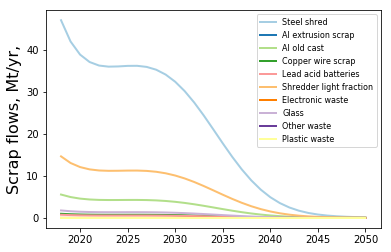

<Figure size 2520x1800 with 0 Axes>

DEBUG (ticker.py <tick_values>): vmin 2.2057571919073273e-05 vmax 94.28018529257756
DEBUG (ticker.py <tick_values>): ticklocs array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02, 1.e+03])
DEBUG (_base.py <_update_title_position>): update_title_pos
DEBUG (ticker.py <tick_values>): vmin 2.2057571919073273e-05 vmax 94.28018529257756
DEBUG (ticker.py <tick_values>): ticklocs array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02, 1.e+03])
DEBUG (ticker.py <tick_values>): vmin 2.2057571919073273e-05 vmax 94.28018529257756
DEBUG (ticker.py <tick_values>): ticklocs [2e-06, 3e-06, 4e-06, 4.9999999999999996e-06, 6e-06, 7e-06, 8e-06, 9e-06, 2e-05, 3.0000000000000004e-05, 4e-05, 5e-05, 6.000000000000001e-05, 7.000000000000001e-05, 8e-05, 9e-05, 0.0002, 0.00030000000000000003, 0.0004, 0.0005, 0.0006000000000000001, 0.0007, 0.0008, 0.0009000000000000001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.02, 0.03, 

DEBUG (_base.py <_update_title_position>): update_title_pos
DEBUG (ticker.py <tick_values>): vmin 2.2057571919073273e-05 vmax 94.28018529257756
DEBUG (ticker.py <tick_values>): ticklocs array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02, 1.e+03])
DEBUG (ticker.py <tick_values>): vmin 2.2057571919073273e-05 vmax 94.28018529257756
DEBUG (ticker.py <tick_values>): ticklocs [2e-06, 3e-06, 4e-06, 4.9999999999999996e-06, 6e-06, 7e-06, 8e-06, 9e-06, 2e-05, 3.0000000000000004e-05, 4e-05, 5e-05, 6.000000000000001e-05, 7.000000000000001e-05, 8e-05, 9e-05, 0.0002, 0.00030000000000000003, 0.0004, 0.0005, 0.0006000000000000001, 0.0007, 0.0008, 0.0009000000000000001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 200.0, 300.

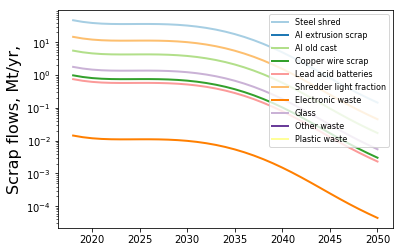

<Figure size 2520x1800 with 0 Axes>

In [17]:
width = 35
height = 25

WasteGroups    = IndexTable.Classification[IndexTable.set_index('IndexLetter').index.get_loc('w')].Items
WasteGroups[1] = 'Al extrusion scrap'
WasteGroups[5] = 'Shredder light fraction'
MyColorCycle = pylab.cm.Paired(np.arange(0,1,0.1)) # select 10 colors from the 'Paired' color map.

# plot at linear scale
fig, ax = plt.subplots()
plt.figure(figsize=(width, height))
for m in range(0,len(WasteGroups)):
    ax.plot(PassengerVehicleFleet_MFA_System.IndexTable['Classification']['Time'].Items[28::], 
            Future_Scrap_Availability_tm[:,m],
            color = MyColorCycle[m,:], linewidth = 2)
ax.set_ylabel('Scrap flows, Mt/yr,',fontsize =16)
ax.legend(WasteGroups, loc='upper right',prop={'size':8})
fig.savefig('ScrapFlows_2017', dpi = 400)  

# plot at log scale
fig, ax = plt.subplots()
plt.figure(figsize=(width, height))
for m in range(0,len(WasteGroups)):
    ax.semilogy(PassengerVehicleFleet_MFA_System.IndexTable['Classification']['Time'].Items[28::], 
            Future_Scrap_Availability_tm[:,m],
            color = MyColorCycle[m,:], linewidth = 2)
ax.set_ylabel('Scrap flows, Mt/yr,',fontsize =16)
ax.legend(WasteGroups, loc='upper right',prop={'size':8})

One can see that the pre-2020 outflows will decline sharply by about 25%, before they reach a plateau between ca. 2021 and 2029. This plateau is probably the consequence of two peaks overlapping, one pre-2017 peak (from 2002 +/- 5 years cars) and one ca. 2027 (from 2012 +/- 5 years cars). To find out which countries are causing this behaviour, let' zoom into the region-specific results! The value for electronic waste is very low because due to data limitations, it was assumed that all copper goes into the copper wire scrap fraction and all plastic to the shredder light fraction.

DEBUG (_base.py <_update_title_position>): update_title_pos
DEBUG (_base.py <_update_title_position>): update_title_pos
DEBUG (_base.py <_update_title_position>): update_title_pos
DEBUG (_base.py <_update_title_position>): update_title_pos
DEBUG (_base.py <_update_title_position>): update_title_pos
DEBUG (_base.py <_update_title_position>): update_title_pos


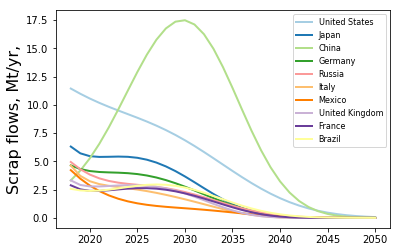

<Figure size 2520x1800 with 0 Axes>

In [18]:
width = 35
height = 25

# We want to plot the ten countries with the largest EoL vehicle flows in 2020:
Sort = np.argsort(Future_Material_Outflow_trm[2,:,:].sum(axis =1)) 
Top10 = [i for i in reversed(Sort[-10::])]

Top10Regions = [IndexTable.Classification[IndexTable.set_index('IndexLetter').index.get_loc('r')].Items[i] for i in Top10]
MyColorCycle = pylab.cm.Paired(np.arange(0,1,0.1)) # select 10 colors from the 'Paired' color map.
fig, ax = plt.subplots()
plt.figure(figsize=(width, height))
for m in range(0,len(Top10)):
    ax.plot(PassengerVehicleFleet_MFA_System.IndexTable['Classification']['Time'].Items[28::], 
            Future_Material_Outflow_trm[:,Top10[m],:].sum(axis =1),
            color = MyColorCycle[m,:], linewidth = 2)
ax.set_ylabel('Scrap flows, Mt/yr,',fontsize =16)
ax.legend(Top10Regions, loc='upper right',prop={'size':8})
fig.savefig('ScrapFlows_2017_Top10Regions', dpi = 400)  

The total outflow from the 2017 stock is indeed the consequence of two overlapping peaks, one resulting from the constantly high car sales in the richest countries, and the later one resulting from the recent sharp increase of vehicle registration in China.


### 6) Performing a Monte-Carlo-Simulation

ODYM has no built-in MC tool yet, as practices still need to evolve and the different application cases vary a lot.
Re-sampling an entire parameter from the Uncertainty information is easy to implement but often very inefficient, as, like in this case, few actually known parameter values are replicated to span all countries and age-cohorts.

Here, we therefore sample the 25 original material content array only, and replicate the sampled values to cover all regions and age-cohorts. Of course, this can be changed when more data is available. We sample the material content per vehicle NMC times from its defined distribution and re-calculate the stock and outflow variables.

The result can be visualized in box plots, for example, as shown below.

In [19]:
Mylog.info('### 6 - Performing a Monte-Carlo-Simulation')

NMC                = 2000 # Number of Monte-Carlo runs
MatContent_Samples = np.zeros((NMC,NM)) # define sample array for material content
MatStock_2017_MC   = np.zeros((NMC,NM)) # define sample array for material stock
MatOFlow_2017_MC   = np.zeros((NMC,NM)) # define sample array for material in EoL vehicles

# 1) re-sample the material composition
for m in range(0,NM):
    UncParts = ParameterDict['ODYM_Tutorial5_VehicleMaterialContent'].Uncert[m*Nt*NR +20].split(';') # parse uncertainty string for material m
    print(UncParts)
    MatContent_Samples[:,m] = np.random.uniform(float(UncParts[1]),float(UncParts[2]),NMC)

# 2) re-calculate the material stock and the outflow
print('')
for s in range(0,NMC):
    if s % 100 == 0:
        print(s)
    # 2a) Replicate vehicle material content for all countries and age-cohorts
    ParameterDict['ODYM_Tutorial5_VehicleMaterialContent'].Values[:,0,:,:] = np.einsum('m,rc->mrc',MatContent_Samples[s,:],np.ones((NR,Nt)))
    # 2b) Assign aggregated result to result array:
    MatStock_2017_MC[s,:] = np.einsum('mgrc,cgr->m',ParameterDict['ODYM_Tutorial5_VehicleMaterialContent'].Values,GlobalVehicleStock_TimeSeries[27,:,:,:]) / 1e9
    MatOFlow_2017_MC[s,:] = np.einsum('mgrc,cgr->m',ParameterDict['ODYM_Tutorial5_VehicleMaterialContent'].Values,GlobalEoL_Vehicles_TimeSeries[27,:,:,:]) / 1e9


INFO (<ipython-input-19-6f16af93ddda> <<module>>): ### 6 - Performing a Monte-Carlo-Simulation


['13', '705.67', '1058.51', 'none']
['13', '92.70', '139.05', 'none']
['13', '11.25', '45', 'none']
['13', '0.08', '0.12', 'none']
['13', '0', '12.15', 'none']
['13', '0', '2.43', 'none']
['13', '0', '2.43', 'none']
['13', '0', '0.729', 'none']
['13', '0.027', '0.035', 'none']
['13', '0.002', '0.415', 'none']
['13', '0.0011', '0.008', 'none']
['13', '0', '195', 'none']
['13', '0.12', '0.36', 'none']
['13', '9.23', '13.85', 'none']
['13', '0.00', '0.00', 'none']
['13', '0.00', '0.01', 'none']
['13', '0.00', '0.00', 'none']
['13', '0.00', '0.01', 'none']
['13', '0.06', '0.18', 'none']
['13', '130.47', '242.30', 'none']
['13', '17.83', '33.12', 'none']
['13', '24.28', '36.42', 'none']
['13', '3.09', '5.74', 'none']
['13', '0.10', '0.18', 'none']
['13', '5.83', '10.83', 'none']

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


DEBUG (_base.py <_update_title_position>): update_title_pos
DEBUG (font_manager.py <_findfont_cached>): findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=14.0 to DejaVu Sans ('C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf') with score of 0.050000.
DEBUG (font_manager.py <_findfont_cached>): findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf') with score of 0.050000.
DEBUG (_base.py <_update_title_position>): update_title_pos
DEBUG (_base.py <_update_title_position>): update_title_pos
DEBUG (_base.py <_update_title_position>): update_title_pos
DEBUG (_base.py <_update_title_position>): update_title_pos
DEBUG (_base.py <_update_title_position>): update_title_pos
DEBUG (_base.py <_update_title_position>): update_title_pos
DE

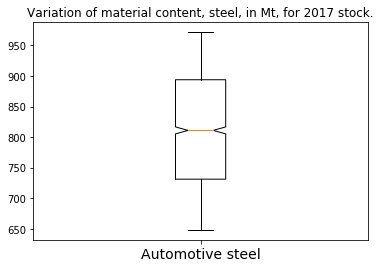

DEBUG (_base.py <_update_title_position>): update_title_pos
DEBUG (_base.py <_update_title_position>): update_title_pos
DEBUG (_base.py <_update_title_position>): update_title_pos
DEBUG (_base.py <_update_title_position>): update_title_pos


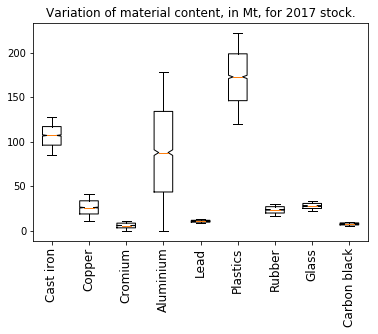

DEBUG (_base.py <_update_title_position>): update_title_pos
DEBUG (_base.py <_update_title_position>): update_title_pos
DEBUG (_base.py <_update_title_position>): update_title_pos
DEBUG (_base.py <_update_title_position>): update_title_pos


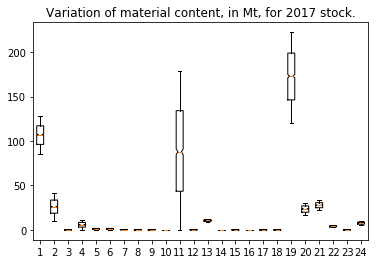

In [20]:
# Steel only (largest by far)
fig, ax = plt.subplots()
ax.boxplot(MatStock_2017_MC[:,0], notch=True)
ax.set_title('Variation of material content, steel, in Mt, for 2017 stock.')
ax.set_xticklabels([IndexTable.Classification[IndexTable.set_index('IndexLetter').index.get_loc('m')].Items[0]], fontsize =14)
fig.savefig('BoxPlot_Steel_2017', dpi = 400)   

# Selected materials (largest second to steel)
fig, ax = plt.subplots()
ax.boxplot(MatStock_2017_MC[:,[1,2,4,11,13,19,20,21,24]], notch=True)
ax.set_title('Variation of material content, in Mt, for 2017 stock.')
PLabels = [IndexTable.Classification[IndexTable.set_index('IndexLetter').index.get_loc('m')].Items[i] for i in[1,2,4,11,13,19,20,21,24]]
PLabels[1] = 'Copper'
ax.set_xticklabels(PLabels, fontsize =12, rotation =90)
fig.savefig('BoxPlot_OtherMaterials_2017_Sel', dpi = 400, bbox_inches='tight')  

# All materials (other than steel)
fig, ax = plt.subplots()
ax.boxplot(MatStock_2017_MC[:,1::], notch=True)
ax.set_title('Variation of material content, in Mt, for 2017 stock.')
fig.savefig('BoxPlot_OtherMaterials_2017', dpi = 400) 

As the material content array comes with min/max uncertainty/variability ranges, from which uniformly distributed samples were drawn, the box plot shows no outliers and the 1./3. quartiles span exactly half the space between min and max values. It does show how the variability of the different material content estimates impacts the variation of the material stock estimate. While the estimates for materials 20-22 (rubber, glass, and ceramics) are rather certain, the one for material 11 (Aluminium) varies substantially, which reflects the high variability of the Al content of passenger vehicles.

If the data are well structured and the model is set up accordingly, performing an uncertainty analysis can be quickly done, as the brevity of the Monte-Carlo-code above shows. 




### 7) Exporting results and close model calculation

It is good practice to export the data behind all figures plotted and those shown in large tables so that other researchers can easily look them up and re-use them. 

In [21]:
# Define excel export function
def ExcelSheetFill(Workbook, Sheetname, values, topcornerlabel=None,
                   rowlabels=None, collabels=None, Style=None,
                   rowselect=None, colselect=None):
    Sheet = Workbook.add_sheet(Sheetname)
    if topcornerlabel is not None:
        if Style is not None:
            Sheet.write(0,0,label = topcornerlabel, style = Style)  # write top corner label
        else:
            Sheet.write(0,0,label = topcornerlabel)  # write top corner label
    if rowselect is None: # assign row select if not present (includes all rows in that case)
        rowselect = np.ones((values.shape[0]))
    if colselect is None: # assign col select if not present (includes all columns in that case)
        colselect = np.ones((values.shape[1]))        
    if rowlabels is not None: # write row labels
         rowindexcount = 0
         for m in range(0,len(rowlabels)):
             if rowselect[m] == 1: # True if True or 1
                 if Style is None:
                     Sheet.write(rowindexcount +1, 0, label = rowlabels[m])
                 else:
                     Sheet.write(rowindexcount +1, 0, label = rowlabels[m], style = Style)
                 rowindexcount += 1
    if collabels is not None: # write column labels
         colindexcount = 0
         for m in range(0,len(collabels)):
             if colselect[m] == 1: # True if True or 1
                 if Style is None:
                     Sheet.write(0, colindexcount +1, label = collabels[m])
                 else:
                     Sheet.write(0, colindexcount +1, label = collabels[m], style = Style)
                 colindexcount += 1   
    # write values:
    rowindexcount = 0
    for m in range(0,values.shape[0]): # for all rows
        if rowselect[m] == 1:
            colindexcount = 0
            for n in range(0,values.shape[1]): # for all columns
                if colselect[n] == 1:
                    Sheet.write(rowindexcount +1, colindexcount + 1, label=values[m, n])
                    colindexcount += 1
            rowindexcount += 1

In [22]:
Mylog.info('### 7 - Exporting results and close model calculation')
#Export to Excel

myfont = xlwt.Font()
myfont.bold = True
mystyle = xlwt.XFStyle()
mystyle.font = myfont
Result_workbook = xlwt.Workbook(encoding = 'ascii') # Export element stock by region

#scrap supply, global total, by scrap type:
ExcelSheetFill(Result_workbook, 'F_4_0_Scrap_Supply_types', Future_Scrap_Availability_tm, topcornerlabel = 'F_4_0: Future scrap availability, by year and scrap group, Mt/yr', rowlabels = IndexTable.Classification[IndexTable.set_index('IndexLetter').index.get_loc('t')].Items[28::], collabels = IndexTable.Classification[IndexTable.set_index('IndexLetter').index.get_loc('w')].Items, Style = mystyle, rowselect = None, colselect = None)
#material outflow, top 10 countries, all scrap types:
ExcelSheetFill(Result_workbook, 'F_2_3_EoL_Material_region', Future_Material_Outflow_trm[:,Top10,:].sum(axis =2), topcornerlabel = 'F_2_3: Future EoL vehicle material flows, by year and region, Mt/yr', rowlabels = IndexTable.Classification[IndexTable.set_index('IndexLetter').index.get_loc('t')].Items[28::], collabels = Top10Regions, Style = mystyle, rowselect = None, colselect = None)

# The Monte-Carlo simulation result can be exported as well but is not exported here to keep the resulting Excel file small.

Result_workbook.save('ODYM_GlobalVehicleFleet_Results.xls')


INFO (<ipython-input-22-bee8b69e33cc> <<module>>): ### 7 - Exporting results and close model calculation


In [23]:
# Close log file

Mylog.info('Script is finished. Terminating logging process and closing all log files.')

# remove all handlers from logger
root = log.getLogger()
root.handlers = []  # required if you don't want to exit the shell
log.shutdown()

INFO (<ipython-input-23-f2e50a277df8> <<module>>): Script is finished. Terminating logging process and closing all log files.


In [24]:
#The end.